##Depemdencies

In [ ]:
!pip install transformers

In [2]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
punctuation = string.punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow import keras
from keras.preprocessing import sequence, text
from keras.layers import Input, Embedding
from string import punctuation
import string
punctuation = string.punctuation
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
stop_words = list(set(stopwords.words('english')))
from sklearn.model_selection import train_test_split
import spacy
from tqdm import tqdm
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from scipy import sparse
from datetime import datetime
from sklearn.metrics import confusion_matrix,r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import coo_matrix, hstack, csr_matrix
import pickle
from gensim.models import KeyedVectors
from gensim.models.fasttext import FastText
from tqdm import tqdm
from transformers import MT5Model, MT5Tokenizer
from transformers import DistilBertConfig, DistilBertTokenizer, TFDistilBertModel
from transformers import pipeline
from transformers import DistilBertModel, DistilBertConfig
from tqdm import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##loading data

FOR CATEGORY 1

In [3]:
data=pd.read_csv('/content/all_tickets.csv')
data.drop_duplicates(inplace = True) # Removing Duplicates
print(data.shape)

(48549, 9)


In [4]:
data.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


##Basic data analysis

In [5]:
#check for na
data.isna().sum()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

We will be prediction the category 

In [6]:
#category value count
data.category.value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [7]:
#ticket type value count
data.ticket_type.value_counts()

1    34621
0    13928
Name: ticket_type, dtype: int64

In [8]:
#business service value count
data.business_service.value_counts()

32    8174
36    3685
68    3589
67    2858
4     2527
      ... 
37       1
69       1
81       1
17       1
0        1
Name: business_service, Length: 103, dtype: int64

In [9]:
#urgency value count
data.urgency.value_counts()

3    34621
1     6748
2     5528
0     1652
Name: urgency, dtype: int64

In [10]:
#impact value count
data.impact.value_counts()

4    34621
3    13184
0      471
2      228
1       45
Name: impact, dtype: int64

We can see that the data is heavently imbalanced in almost all categories,

We can go with the prediction of the ticket type which is least imbalanced 

Lets see the datapoint distrubution of ticket category

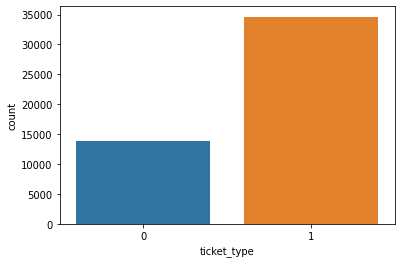

In [11]:
#ticet type plot
sns.countplot(data=data,x='ticket_type')
plt.show()

In [12]:
print('{0} percentage of ticket type is 0'.format(round(data.ticket_type.value_counts()[0]/(len(data.ticket_type))*100,2)))

28.69 percentage of ticket type is 0


##Feature Engg

###Attribute Analysis

We can drop the NA cases as they are fairly low in number

In [13]:
data.dropna(inplace=True)

merging all the columns as one

In [14]:
data['all'] = data[['title', 'body']].apply(lambda x: ' '.join(x), axis=1)

Lets create some features for the data set

Totle word count

In [15]:
data['title_count']=data['title'].apply(lambda x: len([w for w in x.split() if w.isalnum()==True]))
data['body_count']=data['body'].apply(lambda x: len([w for w in x.split() if w.isalnum()==True]))

In [16]:
data.drop(columns=['body','title'],inplace=True)

In [17]:
data['length']=data['all'].apply(lambda x: len(x))

In [18]:
#dropping if length is les than 2
data = data[data.length > 2]

In [19]:
data.head(2)

,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,all,title_count,body_count,length
1,1,6,22,7,26,3,4,connection with icon icon dear please setup ic...,3,15,111
2,1,5,13,7,32,3,4,work experience user work experience user hi w...,3,16,124


In [20]:
data.columns

Index(['ticket_type', 'category', 'sub_category1', 'sub_category2',
       'business_service', 'urgency', 'impact', 'all', 'title_count',
       'body_count', 'length'],
      dtype='object')

In [21]:
num_attrib=['ticket_type','category','sub_category1','sub_category2','business_service','urgency','impact','title_count','body_count','length']

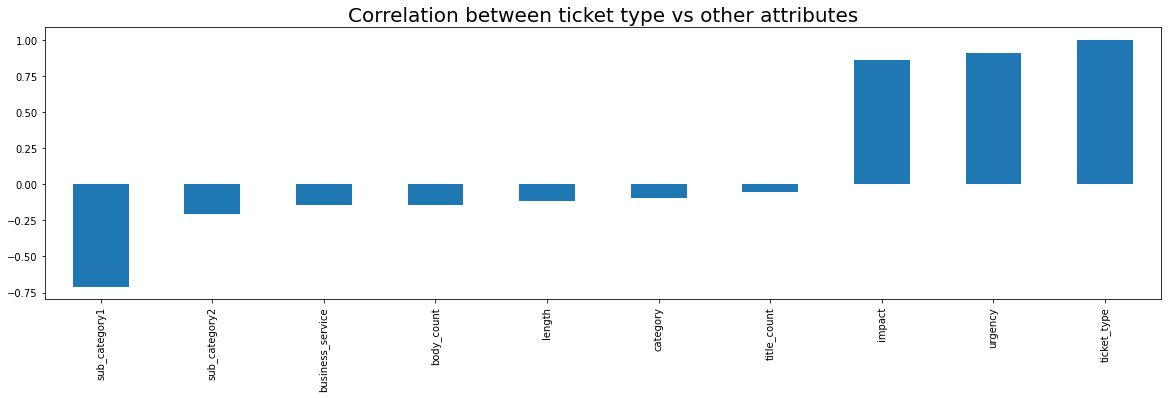

sub_category1      -0.710112
sub_category2      -0.203548
business_service   -0.146391
body_count         -0.141227
length             -0.113739
category           -0.096698
title_count        -0.053826
impact              0.859775
urgency             0.910011
ticket_type         1.000000
Name: ticket_type, dtype: float64

In [22]:
#correlation of numerical features

plt.figure(figsize=(20,5))
temp_df=data[num_attrib].corr()
temp=temp_df.iloc[0].sort_values()
temp.plot(kind='bar')
plt.title('Correlation between ticket type vs other attributes',size=20)
plt.show()
temp

Changing numerical attribute to categorical attribute

In [23]:
#sub_Category1
data.sub_category1.value_counts().keys()

Int64Index([ 2,  3,  1, 13, 21, 51, 22, 15,  9, 14, 12, 32, 39, 30, 54, 50, 45,
            36, 56, 10, 35, 27, 28, 49, 41, 37, 16, 58, 17, 53, 57,  8, 55, 24,
            34, 33, 19, 44, 43,  4, 20, 26, 18, 38, 52,  0, 31,  6, 40, 42,  7,
            48, 23, 46,  5, 11, 47, 25, 29],
           dtype='int64')

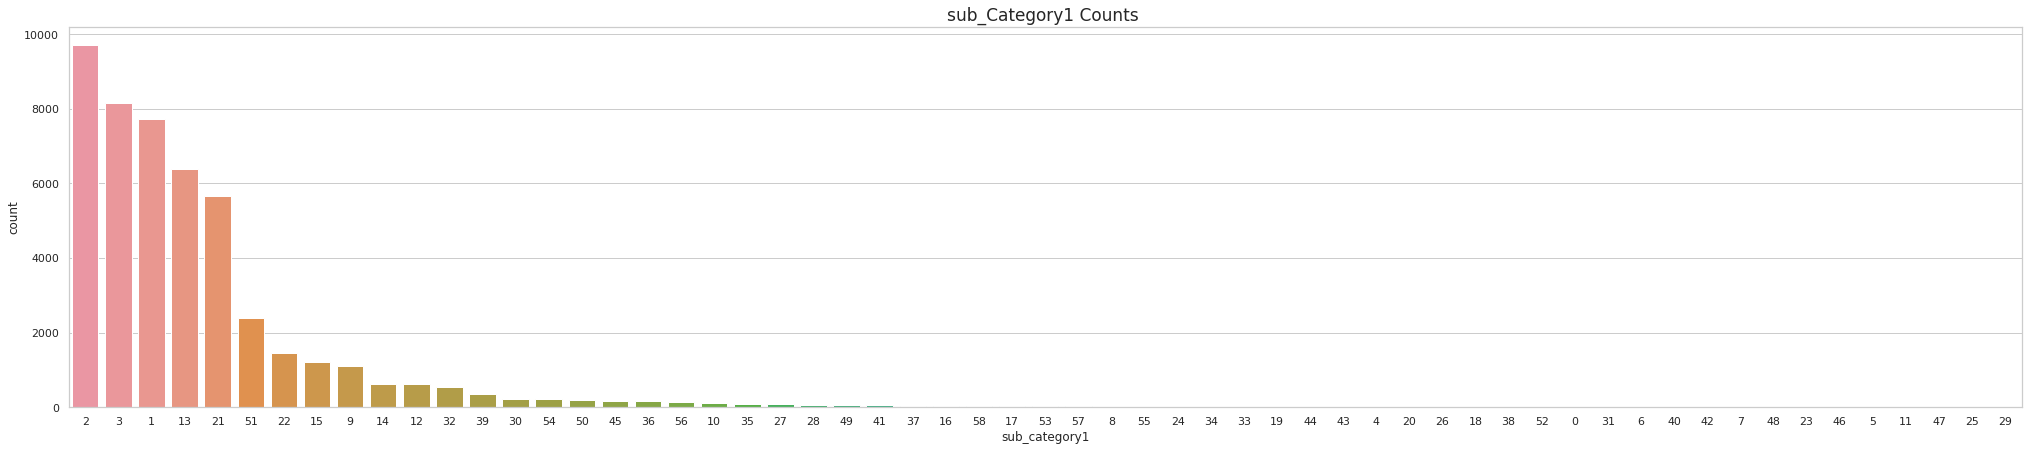

2     9713
3     8157
1     7724
13    6385
21    5662
51    2382
22    1447
15    1209
9     1107
14     620
Name: sub_category1, dtype: int64

In [24]:
#sub_Category1
plt.figure(figsize=(35,7))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="sub_category1",data=data,order=data.sub_category1.value_counts().index)
plt.title('sub_Category1 Counts ',size=17)
plt.show()
data.sub_category1.value_counts()[:10]

We can see that it range form 0-58 so we will divide it into 

0-9-a

10-20-b

21-30-c

31-40-d

41-50-e

50 or geater-f

In [25]:
def conversion(arr):
    bins = np.empty(arr.shape[0], dtype=object)
    for idx, x in enumerate(arr):
        if (x >= 0) & (x < 10):
            bins[idx] = 'sb_1'
        elif (x >= 10) & (x <=20):
            bins[idx] = 'sb_2'
        elif (x >= 21) & (x <=30):
            bins[idx] = 'sb_3'
        elif (x >= 31) & (x <=40):
            bins[idx] = 'sb_4'
        elif (x >= 41) & (x <=50):
            bins[idx] = 'sb_5'
        else:
            bins[idx] = 'sb_6'
            
    return bins

In [26]:
temp_loc=conversion(data['sub_category1'].values)

data['sub_category1'] = temp_loc

In [27]:
data.sub_category1.value_counts()

sb_1    26733
sb_2     9036
sb_3     7490
sb_6     2841
sb_4     1230
sb_5      507
Name: sub_category1, dtype: int64

In [28]:
#subcategory_2
len(data.sub_category2.value_counts().keys())

115

In [29]:
#sub_Category2
data.sub_category2.value_counts().keys()

Int64Index([  7,  21,  41,   0,  88,  23,  94,   1, 105,  87,
            ...
             28,  37,  42,   9, 104,  72,  79,  39, 102,  24],
           dtype='int64', length=115)

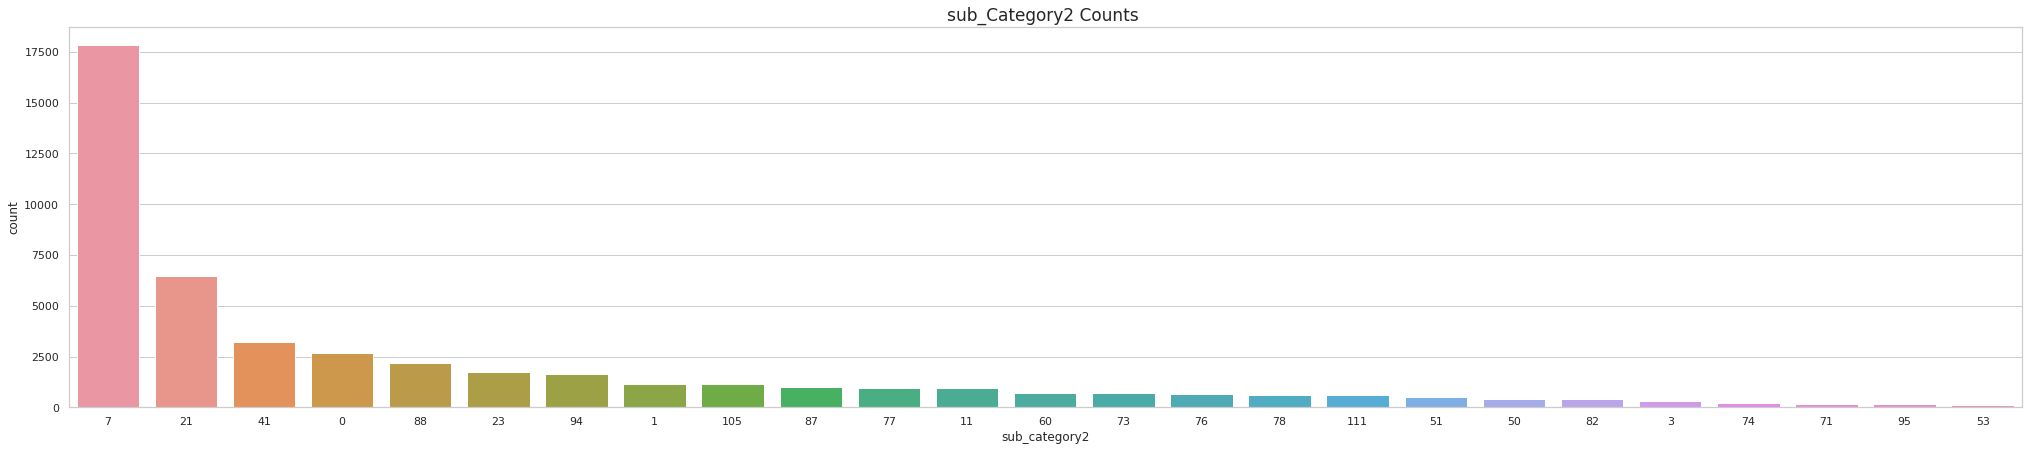

7      17841
21      6476
41      3206
0       2657
88      2200
23      1722
94      1625
1       1143
105     1126
87       994
Name: sub_category2, dtype: int64

In [30]:
#sub_Category2
plt.figure(figsize=(35,7))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="sub_category2",data=data,order=data.sub_category2.value_counts()[:25].index)
plt.title('sub_Category2 Counts ',size=17)
plt.show()
data.sub_category2.value_counts()[:10]

In [31]:
def conversion_2(arr):
    bins = np.empty(arr.shape[0], dtype=object)
    for idx, x in enumerate(arr):
        if (x >= 0) & (x < 10):
            bins[idx] = 'sb2_1'
        elif (x >= 10) & (x <=20):
            bins[idx] = 'sb2_2'
        elif (x >= 21) & (x <=30):
            bins[idx] = 'sb2_3'
        elif (x >= 31) & (x <=40):
            bins[idx] = 'sb2_4'
        elif (x >= 41) & (x <=50):
            bins[idx] = 'sb2_5'
        else:
            bins[idx] = 'sb2_6'
            
    return bins

In [32]:
temp_loc_2=conversion_2(data['sub_category2'].values)

data['sub_category2'] = temp_loc_2

In [33]:
data.sub_category2.value_counts()

sb2_1    22068
sb2_6    12592
sb2_3     8448
sb2_5     3661
sb2_2     1031
sb2_4       37
Name: sub_category2, dtype: int64

In [34]:
#business_service
len(data.business_service.value_counts().keys())

103

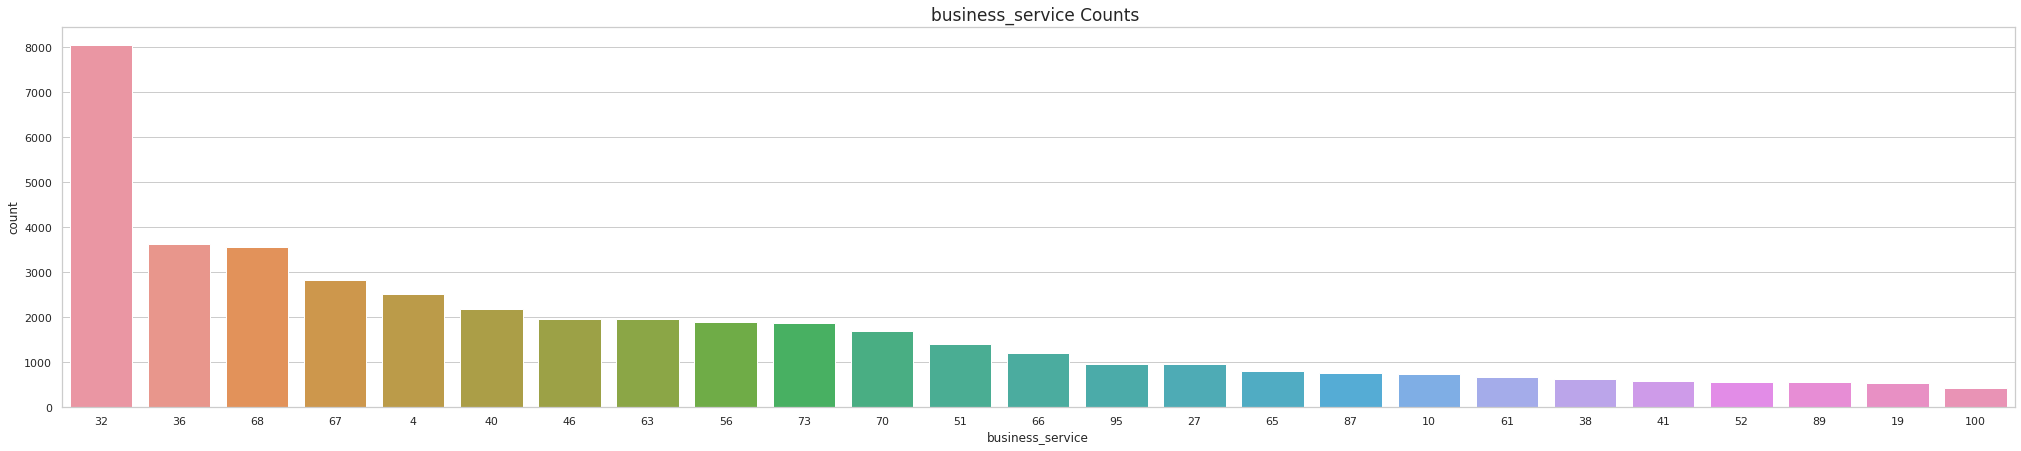

32    8050
36    3633
68    3552
67    2823
4     2507
40    2187
46    1964
63    1955
56    1902
73    1864
Name: business_service, dtype: int64

In [35]:
#business_service
plt.figure(figsize=(35,7))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="business_service",data=data,order=data.business_service.value_counts()[:25].index)
plt.title('business_service Counts ',size=17)
plt.show()
data.business_service.value_counts()[:10]

In [36]:
def conversion_3(arr):
    bins = np.empty(arr.shape[0], dtype=object)
    for idx, x in enumerate(arr):
        if (x >= 0) & (x < 20):
            bins[idx] = 'bs_1'
        elif (x >= 20) & (x <=40):
            bins[idx] = 'bs_2'
        elif (x >= 41) & (x <=60):
            bins[idx] = 'bs_3'
        elif (x >= 61) & (x <=80):
            bins[idx] = 'bs_4'
        else:
            bins[idx] = 'bs_5'
            
    return bins

In [37]:
temp_loc_3=conversion_3(data['business_service'].values)

data['business_service'] = temp_loc_3

In [38]:
data.business_service.value_counts()

bs_2    16337
bs_4    15603
bs_3     7799
bs_1     4554
bs_5     3544
Name: business_service, dtype: int64

In [39]:
#urgency
data.urgency.value_counts()

3    34033
1     6694
2     5462
0     1648
Name: urgency, dtype: int64

In [40]:
#impact
data.impact.value_counts()

4    34033
3    13068
0      465
2      227
1       44
Name: impact, dtype: int64

We will convert these into categorical variable as well

###Wordcloud Text Data

Leta look at the word cloud distrubution of one of the most used words,
of unigram distrubtion

In [41]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud(data, column):  # ref: https://www.geeksforgeeks.org/generating-word-cloud-python/
    comment_words = ''
    stopwords = set(STOPWORDS)

    for val in data[column]:	
	# typecaste each val to string
	    val = str(val)
	# split the value
	    tokens = val.split()	
	# Converts each token into lowercase
	    for i in range(len(tokens)):
		    tokens[i] = tokens[i].lower()	
	    comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 500, height = 300,
				background_color ='black',
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words)
    # plot the WordCloud image					
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

When ticket type is 1

In [42]:
df_1=data[data['ticket_type']==1]

In [43]:
df_1.head(3)

,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,all,title_count,body_count,length
1,1,6,sb_3,sb2_1,bs_2,3,4,connection with icon icon dear please setup ic...,3,15,111
2,1,5,sb_2,sb2_1,bs_2,3,4,work experience user work experience user hi w...,3,16,124
3,1,5,sb_2,sb2_1,bs_2,3,4,requesting for meeting requesting meeting hi p...,3,11,93


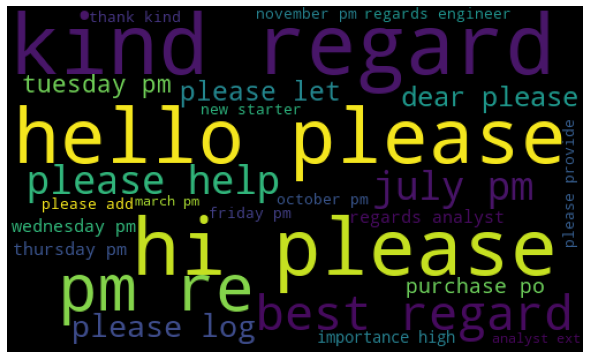

In [44]:
word_cloud(df_1, 'all')

When ticket type is 0

In [45]:
df_0=data[data['ticket_type']==0]

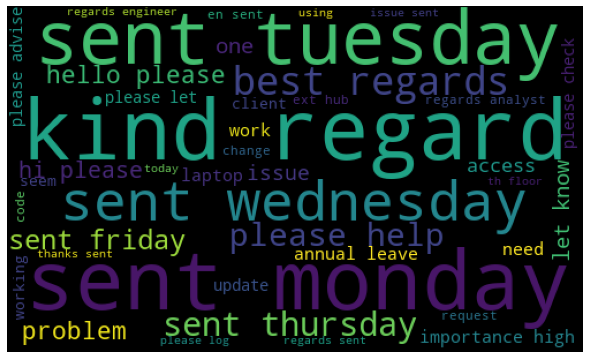

In [46]:
word_cloud(df_0, 'all')

###Text preprocessing

In [47]:
# preprocessing 

import re
from nltk.stem import WordNetLemmatizer  # lemmatizer
stemmer = WordNetLemmatizer()

def preprocess(text):
    
    text = re.sub(r"won\'t", "will not", text)   # decontracting the words
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r'\W', ' ', str(text))  # Remove all the special characters

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove all single characters 
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # replace all the words except "A-Za-z_" with space

    text = re.sub(r'[^\w\s]','',text)

    text = ' '.join(e for e in text.split() if e.lower() not in stopwords.words('english') and len(e)>2)  # convert to lower and remove stopwords discard words whose len < 2
    
    text = text.lower().strip()   # strip

    # Lemmatization
    tokens = text.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 2]

    new_text = ' '.join(tokens)

    return new_text

In [48]:
data['all']= data['all'].apply(lambda x: preprocess(x))

##EDA

Numerical data analysis

In [49]:
data.dtypes

ticket_type          int64
category             int64
sub_category1       object
sub_category2       object
business_service    object
urgency              int64
impact               int64
all                 object
title_count          int64
body_count           int64
length               int64
dtype: object

Lets do some feature analysis of umerical attributes

In [50]:
data.head()

,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,all,title_count,body_count,length
1,1,6,sb_3,sb2_1,bs_2,3,4,connection icon icon dear please setup icon pe...,3,15,111
2,1,5,sb_2,sb2_1,bs_2,3,4,work experience user work experience user work...,3,16,124
3,1,5,sb_2,sb2_1,bs_2,3,4,requesting meeting requesting meeting please h...,3,11,93
4,1,4,sb_1,sb2_6,bs_1,3,4,reset password external account expire day ask...,5,140,948
5,1,4,sb_1,sb2_1,bs_5,3,4,mail verification warning got attached please ...,1,14,115


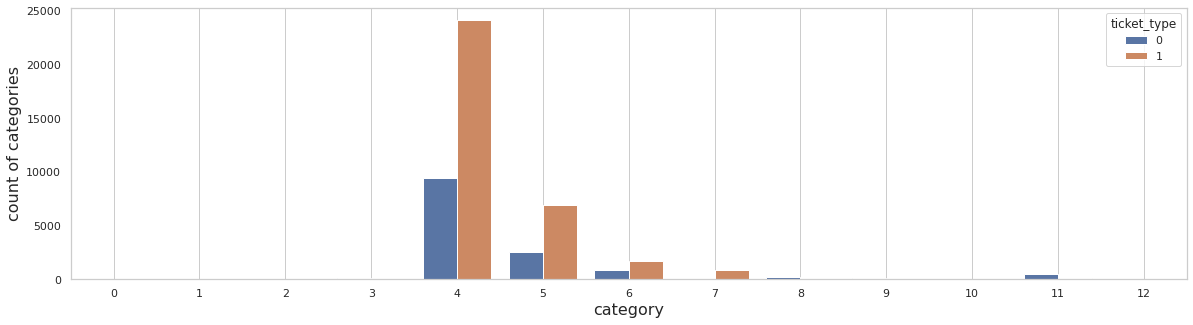

4     33569
5      9492
6      2586
7       907
11      605
8       237
9       181
3       136
1        71
12       44
0         4
2         3
10        2
Name: category, dtype: int64

In [51]:
#category
plt.figure(figsize=(20,5))
sns.countplot(data=data,x='category',hue='ticket_type')
plt.xlabel("category", size=16)
plt.ylabel("count of categories", size=16)
plt.grid()
plt.show()

data.category.value_counts()

In [52]:
print('{0} percentage of ticket type is category 4'.format(round(data.category.value_counts()[4]/(len(data))*100,2)))

70.17 percentage of ticket type is category 4


Maximum data belog to one category only 4

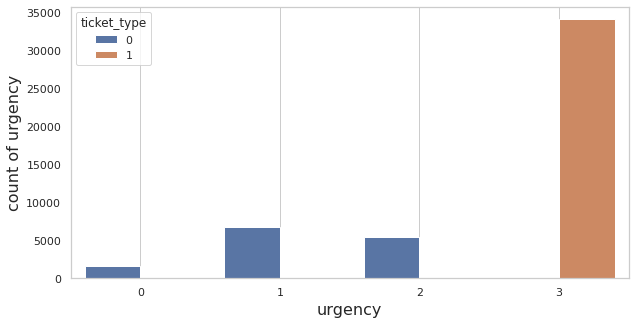

3    34033
1     6694
2     5462
0     1648
Name: urgency, dtype: int64

In [53]:

#urgency
plt.figure(figsize=(10,5))
sns.countplot(data=data,x='urgency',hue='ticket_type')
plt.xlabel("urgency", size=16)
plt.ylabel("count of urgency", size=16)
plt.grid()
plt.show()

data.urgency.value_counts()

Urgencey 0,1,2 are 0 and 3 is 1 this is very stange

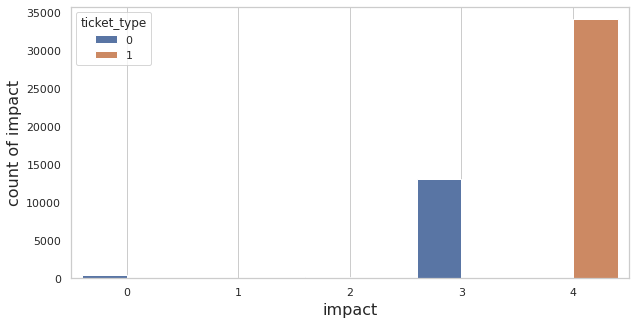

4    34033
3    13068
0      465
2      227
1       44
Name: impact, dtype: int64

In [54]:
#impact
plt.figure(figsize=(10,5))
sns.countplot(data=data,x='impact',hue='ticket_type')
plt.xlabel("impact", size=16)
plt.ylabel("count of impact", size=16)
plt.grid()
plt.show()

data.impact.value_counts()

The distrubution is majorly same as urgency 

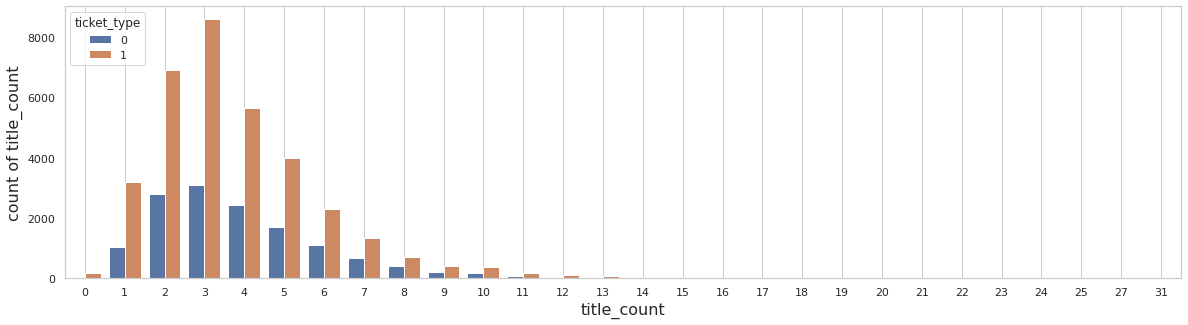

3     11680
2      9732
4      8074
5      5671
1      4199
6      3370
7      1991
8      1124
9       620
10      529
Name: title_count, dtype: int64

In [55]:

#title_count
plt.figure(figsize=(20,5))
sns.countplot(data=data,x='title_count',hue='ticket_type')
plt.xlabel("title_count", size=16)
plt.ylabel("count of title_count", size=16)
plt.grid()
plt.show()

data.title_count.value_counts()[:10]

Title is majorly no more than 3-5 word count

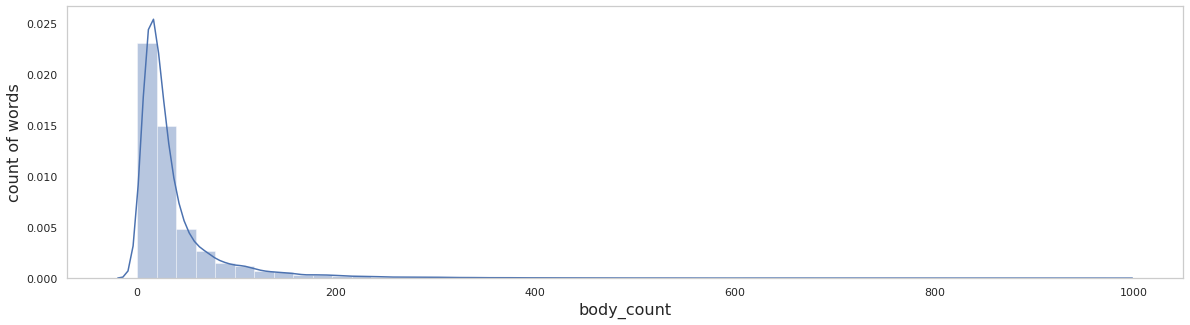

14    1683
12    1604
11    1566
13    1566
15    1493
10    1478
16    1457
17    1451
9     1342
18    1267
Name: body_count, dtype: int64

In [56]:
#body_count
plt.figure(figsize=(20,5))
sns.distplot(data['body_count'])
plt.xlabel("body_count", size=16)
plt.ylabel("count of words", size=16)
plt.grid()
plt.show()
data.body_count.value_counts()[:10]

Maximum words are under 150 words 

Lets plot the CDF plot

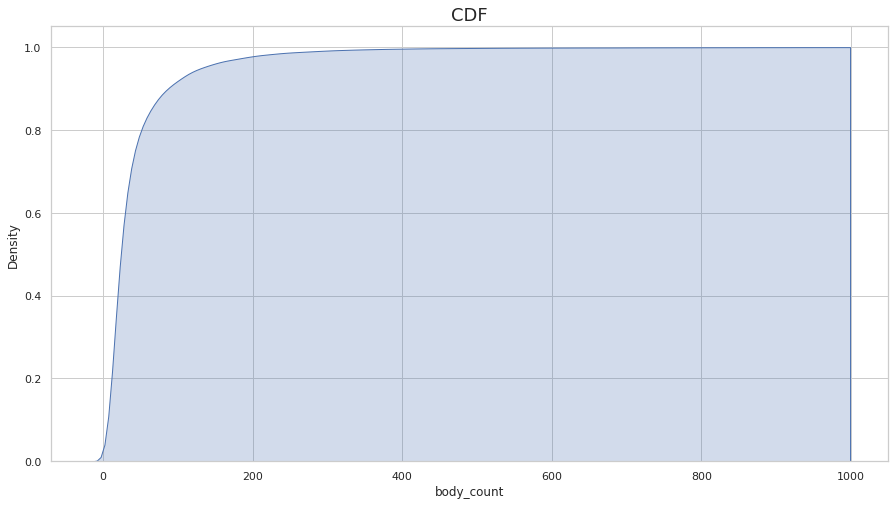

In [57]:
plt.figure(figsize=(15,8))
sns.kdeplot(data['body_count'], shade=True, cumulative=True)
plt.title('CDF',size = 18)
plt.show()

##Categorical Encoding

In [58]:
cat_attrib=['category', 'sub_category1','urgency', 'impact','business_service','sub_category2']

In [59]:
#getdummies of categorical attributes
cat_df=data[cat_attrib]

cat_df=pd.get_dummies(data=cat_df, columns=['category', 'sub_category1','urgency', 'impact','business_service','sub_category2'])
cat_df.head()

,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12,sub_category1_sb_1,sub_category1_sb_2,sub_category1_sb_3,sub_category1_sb_4,sub_category1_sb_5,sub_category1_sb_6,urgency_0,urgency_1,urgency_2,urgency_3,impact_0,impact_1,impact_2,impact_3,impact_4,business_service_bs_1,business_service_bs_2,business_service_bs_3,business_service_bs_4,business_service_bs_5,sub_category2_sb2_1,sub_category2_sb2_2,sub_category2_sb2_3,sub_category2_sb2_4,sub_category2_sb2_5,sub_category2_sb2_6
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0


##Train Test Split

In [60]:
data.drop(['category', 'sub_category1','urgency', 'impact','business_service','sub_category2'],inplace=True,axis=1)

In [61]:
data_new=pd.concat([data,cat_df], axis=1)

In [107]:
data_x=data_new.drop(columns=['ticket_type'])
data_y=data_new['ticket_type']

In [108]:
train_x,test_x,train_y,test_y=train_test_split(data_x,data_y,stratify=data_y,test_size=0.2,random_state=42)

In [109]:
train_x.head()

,all,title_count,body_count,length,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12,sub_category1_sb_1,sub_category1_sb_2,sub_category1_sb_3,sub_category1_sb_4,sub_category1_sb_5,sub_category1_sb_6,urgency_0,urgency_1,urgency_2,urgency_3,impact_0,impact_1,impact_2,impact_3,impact_4,business_service_bs_1,business_service_bs_2,business_service_bs_3,business_service_bs_4,business_service_bs_5,sub_category2_sb2_1,sub_category2_sb2_2,sub_category2_sb2_3,sub_category2_sb2_4,sub_category2_sb2_5,sub_category2_sb2_6
33166,investigate new available wednesday july avail...,5,38,314,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
12225,notification maintenance work virtual infrastr...,8,43,345,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
44042,issue test sent saturday march incident issue ...,3,49,334,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
40661,desktop outlook client keep asking credential ...,8,49,376,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
25230,client name change friday december client name...,3,72,460,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [65]:
train_x.shape

(38269, 43)

In [66]:
test_x.shape

(9568, 43)

##Normalizing Numerical Data

lets standardize the numerical data for the modelling

In [110]:
#minmaxing the numerical attributes
import sklearn
num_attrib=['title_count','body_count','length']

s_scalar = sklearn.preprocessing.MinMaxScaler()
train_x[num_attrib] = s_scalar.fit_transform(train_x[num_attrib])
test_x[num_attrib]=s_scalar.transform(test_x[num_attrib])

file_n = open('minmax_scale_cs2_new_07.pkl', 'wb')

# dump information to that file
pickle.dump(s_scalar, file_n)
file_n.close()

In [111]:
train_x.head()

,all,title_count,body_count,length,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12,sub_category1_sb_1,sub_category1_sb_2,sub_category1_sb_3,sub_category1_sb_4,sub_category1_sb_5,sub_category1_sb_6,urgency_0,urgency_1,urgency_2,urgency_3,impact_0,impact_1,impact_2,impact_3,impact_4,business_service_bs_1,business_service_bs_2,business_service_bs_3,business_service_bs_4,business_service_bs_5,sub_category2_sb2_1,sub_category2_sb2_2,sub_category2_sb2_3,sub_category2_sb2_4,sub_category2_sb2_5,sub_category2_sb2_6
33166,investigate new available wednesday july avail...,0.161290,0.037832,0.043807,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
12225,notification maintenance work virtual infrastr...,0.258065,0.042945,0.048231,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
44042,issue test sent saturday march incident issue ...,0.096774,0.049080,0.046661,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
40661,desktop outlook client keep asking credential ...,0.258065,0.049080,0.052654,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
25230,client name change friday december client name...,0.096774,0.072597,0.064640,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


##Vectorizing Types 

Lets start with the word embedding

We will use 3 models for the woed embedding:

1 Word2Vec

2 Fast Text

3 BERT

4 TFIDF

###W2Vec Model

In [69]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-09-05 07:57:28--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  63.1MB/s    in 23s     

2021-09-05 07:57:52 (68.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [70]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [71]:
def w2v(X):
    words=list(word2vec.vocab)
    x = []
    for sentence in tqdm(X): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        for word in sentence.split(): # for each word in a review/sentence
            if word in words:
                vector += word2vec[word]
        x.append(vector)
    x = np.array(x)
    return x

###fast text 300d

In [72]:
!wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://fasttext.cc/" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" -c -O 'wiki-news-300d-1M.vec.zip'

--2021-09-05 08:00:07--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  30.9MB/s    in 22s     

2021-09-05 08:00:29 (30.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [73]:
! unzip /content/wiki-news-300d-1M.vec.zip

Archive:  /content/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [74]:
model_ft = KeyedVectors.load_word2vec_format('/content/wiki-news-300d-1M.vec')

In [75]:
def fast_text_embed(X):
    words=list(model_ft.vocab)
    x = []
    for sentence in tqdm(X): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        for word in sentence.split(): # for each word in a review/sentence
            if word in words:
                vector += model_ft[word]
        x.append(vector)
    x = np.array(x)
    return x

###Bert embedding

1- The config contains the settings for bert, the config tunes the selected bert type in our case it is distilbert-bert-uncased, you can see we have mentioned in the config that we want the configuration of distilbert-bert-uncased and enabled hidden states to return which tunes the bert to return layers output in our bert.


2- The model as name suggest it makes our model based on the settings we made in the config. Additional, it downloads the required weights ,implement the tokenizer, padding and masking.


3- The pipeline makes our life easier it flows the  codes in sequential methods as required by the bert and it takes task for which we are making to save us from complex coding and makes us less prone to mistakes. The pipeline can take many tasks/commands like NER, Sentiment Analysis, Feature Extraction and Question Answering, etc

In [76]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Loading Tokenizer

# Initializing a DistilBERT configuration
configuration = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_hidden_states = True)

# Initializing a model from the configuration
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = configuration)

# Accessing the model configuration

nlp = pipeline('feature-extraction', model = model, tokenizer = tokenizer, framework = "tf") # Defining Pipling as Feature-Extractor
def convertion(string):
    inputs = tokenizer(string, return_tensors = "tf")
    outputs = model(inputs)
    # Concatinating Only 3,4,5,6 layer of BERT
    outputs = np.concatenate((outputs[1][6][0,0,:],outputs[1][5][0,0,:],outputs[1][4][0,0,:],outputs[1][3][0,0,:]), axis=0) 
    
    return np.array(outputs)

def convertor(X):
    sent =[]
    vec=[]
    for i in tqdm(X,position=0, leave=True):
        text = i[:512]
        vec.append(convertion(text))
    return vec

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


###TFIDF

In [90]:
#tfidf
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=1000)
tfidf.fit(train_x['all'])
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

In [ ]:
tfidf.vocabulary_

Lers start the modelling part and see which performs the best

##Utility Function

In [112]:
#utility function
from sklearn.metrics import classification_report

def resultant(y_true, y_pred,model,vect,clf):

  val_1=mean_absolute_error(y_true, y_pred)
  print("*"*12,model,"*"*5,vect,"*"*12)
  print ("\n Classification report : \n",classification_report(y_true, y_pred))
  print('Mean Absolute Error:{0}'.format(val_1))
  print("Fl score: ", f1_score(y_true, y_pred))
  print('Best Estimators are',clf)
  print("=="*30,'\n')

  conf = confusion_matrix(y_true, y_pred).round(3)
  plt.figure(figsize=(9,6))
  sns.heatmap(conf, annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black')
  
  plt.title("Confusion Matrix",fontsize=20)
  plt.xlabel("Predicted Value",fontsize=16)
  plt.ylabel("True Value",fontsize=16)


##Modelling Data

###Vectors selection

In [113]:
def vect_models(train_x, test_x, vectorizor_mode):

        if vectorizor_mode.lower() == 'tfidf':

            model=pickle.load(open('/content/tfidf.pkl','rb'))
            train_x = model.transform(train_x)
            test_x = model.transform(test_x)
            return train_x.todense(),test_x.todense()

        if vectorizor_mode.lower() == 'w2v':

            train_x = w2v(train_x)
            test_x = w2v(test_x)
            return train_x,test_x

        if vectorizor_mode.lower() == 'fast':

            train_x = fast_text_embed(train_x)
            test_x = fast_text_embed(test_x)
            return train_x,test_x

        if vectorizor_mode.lower() == 'bert':

            train_x = np.array(convertor(train_x))
            test_x = np.array(convertor(test_x)) 
            return train_x,test_x
            
        

###Model Selection

In [129]:
def knn_model(X,y):
  knn = KNeighborsClassifier()
  k_range = list(range(1,3))
  param_grid = dict(n_neighbors=k_range)
  grid = GridSearchCV(knn, param_grid, scoring='accuracy')
  grid.fit(X, y)
  return grid.best_params_

def nb_model(X,y):
  mnb =GaussianNB()
  # parameters = { 'alpha': [1, 0.1, 0.01] } 
  parameters = {'var_smoothing': [1e-11, 1e-10, 1e-9]}
  grid = GridSearchCV(mnb, parameters, n_jobs=-1, scoring='accuracy')
  grid.fit(X, y)
  return grid.best_params_

def rf_model(X,y):  
  rf=RandomForestClassifier()
  parameters = {
          'n_estimators': [10, 100, 1000],
          'max_features' : ['sqrt', 'log2']
          }
  grid = GridSearchCV(rf, parameters, scoring='accuracy')
  grid.fit(X, y)
  return grid.best_params_  

###Modelling

In [131]:
def mod_models(train_data, test_data,vectorizor_mode,model_mode):  
        train_x, train_y = train_data
        test_x, test_y = test_data
        
        train_text=train_x['all']
        test_text=test_x['all']

        train_txt,test_txt =vect_models(train_text, test_text, vectorizor_mode)
        
        train_df=pd.concat([pd.DataFrame(train_txt), train_x.drop(['all'],axis=1).reset_index(drop=True)], axis=1)

        test_df=pd.concat([pd.DataFrame(test_txt), test_x.drop(['all'],axis=1).reset_index(drop=True)], axis=1)
        # print(train_df.head())
        # return train_df

        if model_mode.lower() == 'none':

          return train_df,test_df
        
        if model_mode.lower() == 'knn':
          
          clf=knn_model(train_df,train_y)
          my_model = KNeighborsClassifier(**clf)
          my_model.fit(train_df,train_y)

          # pickle.dump(my_model, open('knn'+'_'+vectorizor_mode+'_'+'.sav', 'wb'))

          predictions = my_model.predict(test_df)
          resultant(test_y, predictions,model="KNN Classifier",vect=vectorizor_mode,clf=clf)


        if model_mode.lower() == 'nb':
          
          clf=nb_model(train_df,train_y)
          my_model = GaussianNB(**clf)
          my_model.fit(train_df,train_y)

          # pickle.dump(my_model, open('nb'+'_'+vectorizor_mode+'_'+'.sav', 'wb'))

          predictions = my_model.predict(test_df)
          resultant(test_y, predictions,model="NB Classifier",vect=vectorizor_mode,clf=clf)

        if model_mode.lower() == 'rf':
          
          clf=rf_model(train_df,train_y)          
          my_model = RandomForestClassifier(**clf)
          my_model.fit(train_df,train_y)

          # pickle.dump(my_model, open('rf'+'_'+vectorizor_mode+'_'+'.pkl', 'wb'))

          predictions = my_model.predict(test_df)
          resultant(test_y, predictions,model="RF Classifier",vect=vectorizor_mode,clf=clf)
          
          # return train_df,test_df
      

##Sanity Check of dataset

As dataset is too large we will take a sample of dataset to find the best model and then train in that dataset the whole data

###KNN-TFIDF

************ KNN Classifier ***** tfidf ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.00031354515050167225
Fl score:  0.9997796871557613
Best Estimators are {'n_neighbors': 1}



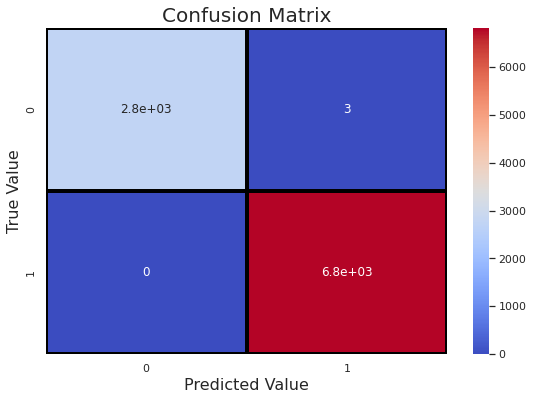

In [91]:
mod_models((train_x,train_y),(test_x,test_y),'tfidf','knn')

###KNN-W2V

100%|██████████| 9568/9568 [04:03<00:00, 39.36it/s]


************ KNN Classifier ***** w2v ************

 Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      2761
           1       0.92      0.93      0.92      6807

    accuracy                           0.89      9568
   macro avg       0.87      0.86      0.87      9568
weighted avg       0.89      0.89      0.89      9568

Mean Absolute Error:0.10859113712374582
Fl score:  0.9240441552745083
Best Estimators are {'n_neighbors': 1}



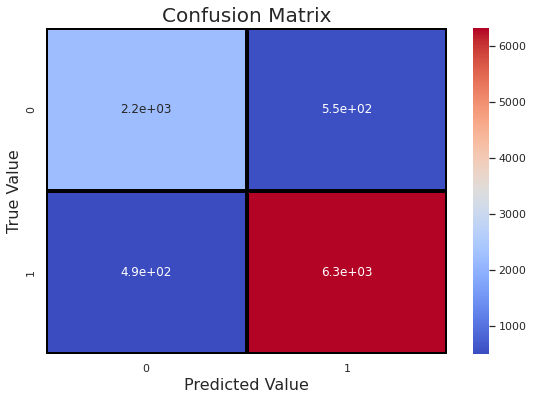

In [89]:
mod_models((train_x,train_y),(test_x,test_y),'w2v','knn')

###KNN-FAST

100%|██████████| 9568/9568 [01:21<00:00, 117.34it/s]


************ KNN Classifier ***** fast ************

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      2761
           1       0.94      0.93      0.93      6807

    accuracy                           0.91      9568
   macro avg       0.89      0.89      0.89      9568
weighted avg       0.91      0.91      0.91      9568

Mean Absolute Error:0.09228678929765886
Fl score:  0.9349251971405409
Best Estimators are {'n_neighbors': 1}



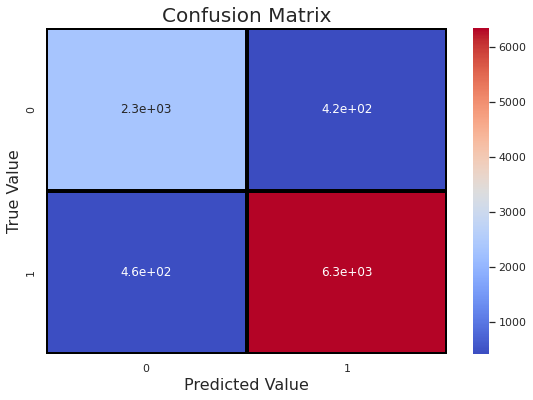

In [92]:
mod_models((train_x,train_y),(test_x,test_y),'fast','knn')

###KNN-BERT

100%|██████████| 9568/9568 [15:38<00:00, 10.20it/s]


************ KNN Classifier ***** bert ************

 Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      2761
           1       0.96      0.97      0.96      6807

    accuracy                           0.95      9568
   macro avg       0.94      0.94      0.94      9568
weighted avg       0.95      0.95      0.95      9568

Mean Absolute Error:0.04995819397993311
Fl score:  0.9649508725619592
Best Estimators are {'n_neighbors': 1}



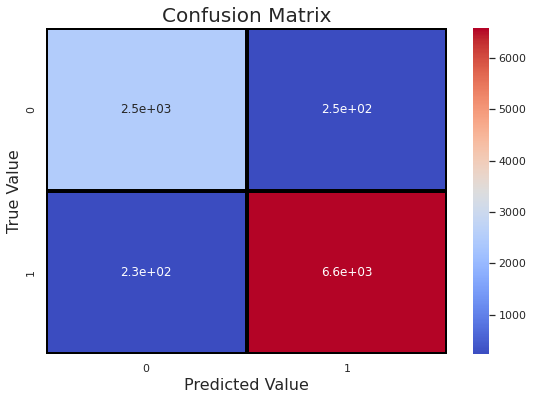

In [93]:
mod_models((train_x,train_y),(test_x,test_y),'bert','knn')

###NAIVE BAYES-TFIDF

************ NB Classifier ***** tfidf ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'alpha': 1}



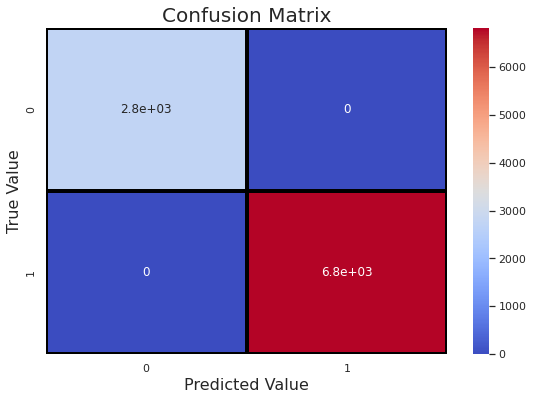

In [118]:
mod_models((train_x,train_y),(test_x,test_y),'tfidf','nb')

###NAIVE BAYES-W2V

100%|██████████| 9568/9568 [03:56<00:00, 40.49it/s]


          0         1  ...  sub_category2_sb2_5  sub_category2_sb2_6
0  0.280441  0.678833  ...                    0                    1
1 -1.248657  0.450996  ...                    0                    1
2  1.902130  0.845093  ...                    0                    0
3 -0.728882 -1.240494  ...                    1                    0
4 -0.530609  0.564087  ...                    0                    0

[5 rows x 342 columns]
************ NB Classifier ***** w2v ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'var_smoothing': 1e-11}



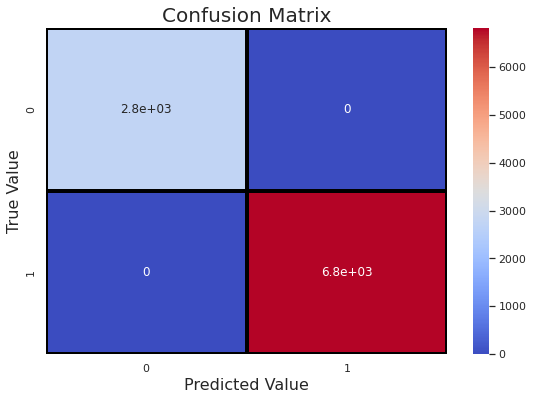

In [130]:
mod_models((train_x,train_y),(test_x,test_y),'w2v','nb')

###NAIVE BAYES-FAST

100%|██████████| 9568/9568 [01:20<00:00, 118.62it/s]


************ NB Classifier ***** fast ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'var_smoothing': 1e-11}



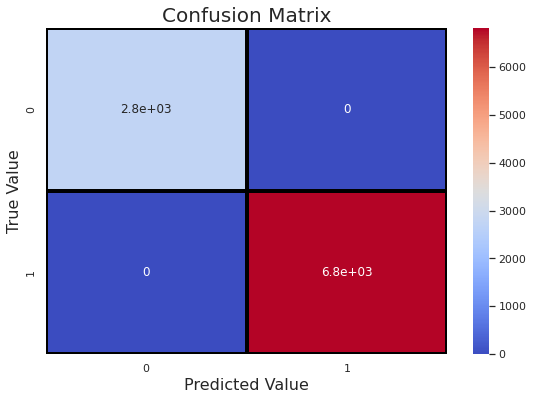

In [132]:
mod_models((train_x,train_y),(test_x,test_y),'fast','nb')

###NAIVE BAYES-BERT

100%|██████████| 9568/9568 [15:14<00:00, 10.46it/s]


************ NB Classifier ***** bert ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'var_smoothing': 1e-11}



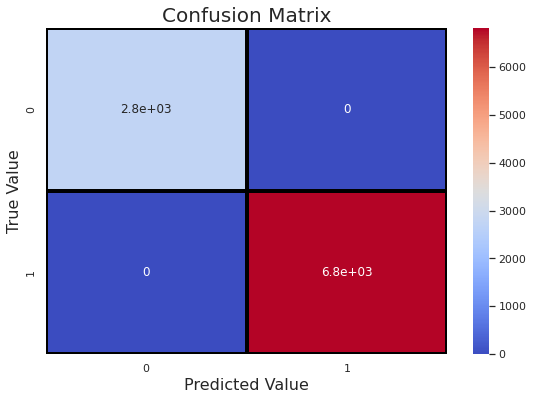

In [133]:
mod_models((train_x,train_y),(test_x,test_y),'bert','nb')

###RANDOM FOREST-TFIDF

************ RF Classifier ***** tfidf ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'max_features': 'sqrt', 'n_estimators': 10}



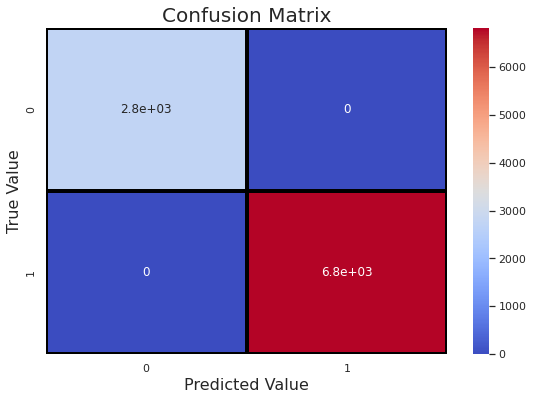

In [134]:
mod_models((train_x,train_y),(test_x,test_y),'tfidf','rf')

###RANDOM FOREST-W2V

100%|██████████| 9568/9568 [03:56<00:00, 40.41it/s]


************ RF Classifier ***** w2v ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'max_features': 'sqrt', 'n_estimators': 100}



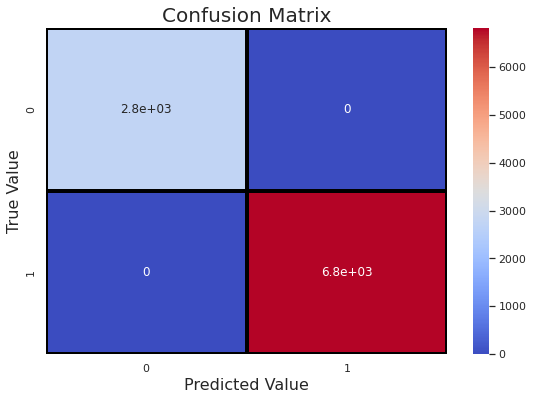

In [135]:
mod_models((train_x,train_y),(test_x,test_y),'w2v','rf')

###RANDOM FOREST-FAST

100%|██████████| 9568/9568 [01:17<00:00, 122.71it/s]


************ RF Classifier ***** fast ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'max_features': 'sqrt', 'n_estimators': 10}



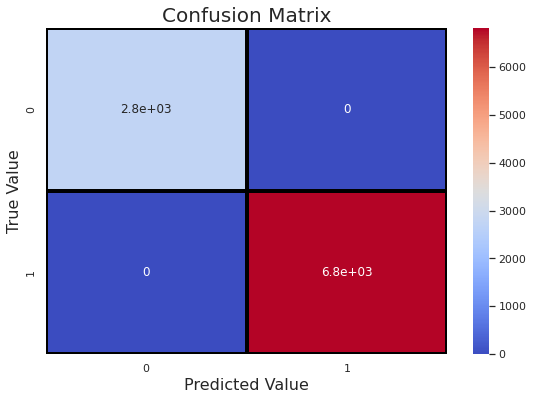

In [ ]:
mod_models((train_x,train_y),(test_x,test_y),'fast','rf')

###RANDOM FOREST-BERT

100%|██████████| 9568/9568 [11:00<00:00, 14.49it/s]


************ RF Classifier ***** bert ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {'max_features': 'sqrt', 'n_estimators': 100}



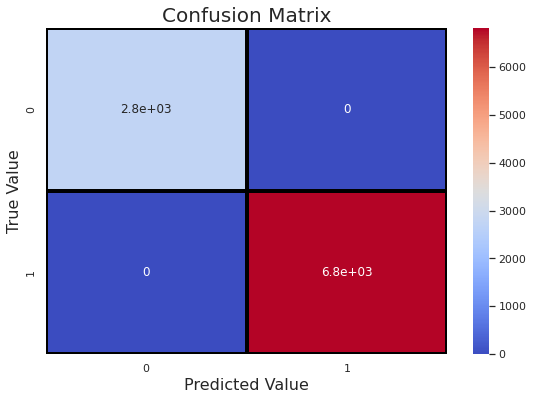

In [ ]:
mod_models((train_x,train_y),(test_x,test_y),'bert','rf')

We can see that random forest is giving the best result so we will go with random forest and Word2Vec

##Best model 

In [136]:
my_model = RandomForestClassifier(max_features= 'sqrt', n_estimators= 100)

In [137]:
train_text=train_x['all']
test_text=test_x['all']

train_txt,test_txt =vect_models(train_text, test_text, 'w2v')

train_df=pd.concat([pd.DataFrame(train_txt), train_x.drop(['all'],axis=1).reset_index(drop=True)], axis=1)
test_df=pd.concat([pd.DataFrame(test_txt), test_x.drop(['all'],axis=1).reset_index(drop=True)], axis=1)

100%|██████████| 9568/9568 [04:02<00:00, 39.51it/s]


In [138]:
my_model.fit(train_df,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [139]:
predictions = my_model.predict(test_df)

In [140]:
#saving model
pickle.dump(my_model, open('/content/drive/MyDrive/dataset_link/rf_w2v_0.pkl', 'wb'))

In [141]:
len(predictions)

9568

************ Random Forest ***** TFIDF ************

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2761
           1       1.00      1.00      1.00      6807

    accuracy                           1.00      9568
   macro avg       1.00      1.00      1.00      9568
weighted avg       1.00      1.00      1.00      9568

Mean Absolute Error:0.0
Fl score:  1.0
Best Estimators are {max_features: sqrt ,n_estimators: 100}



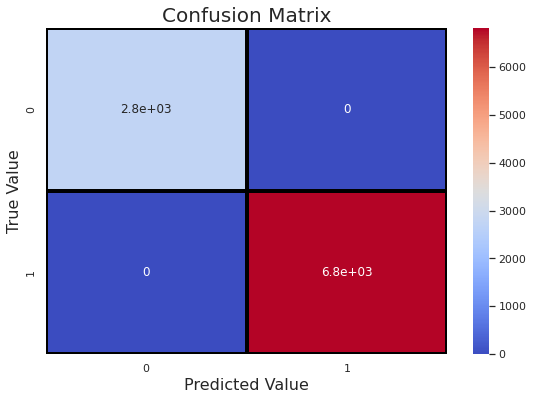

In [142]:
resultant(test_y, predictions,model="Random Forest",vect='TFIDF',clf='{max_features: sqrt ,n_estimators: 100}')